<a href="https://colab.research.google.com/github/jsalbert/biotorch/blob/release/notebooks/benchmark/metrics_visualizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
!pip install biotorch --upgrade
!git clone https://github.com/jsalbert/biotorch.git

     |████████████████████████████████| 35.3 MB 57 kB/s 
     |████████████████████████████████| 56 kB 3.9 MB/s 
     |████████████████████████████████| 100 kB 9.5 MB/s 
  Created wheel for biotorch: filename=biotorch-0.0.6-py3-none-any.whl size=78972 sha256=1207debd8bc8fed2251cd895cb510afb428d1fc873ed26a9e8a902cfd9457f58
  Stored in directory: /root/.cache/pip/wheels/bd/03/48/3f2559d4ef6135245075196550fe977448c0a7308cf561f764
Successfully built biotorch
  Attempting uninstall: jsonschema
    Found existing installation: jsonschema 2.6.0
    Uninstalling jsonschema-2.6.0:
      Successfully uninstalled jsonschema-2.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nbclient 0.5.4 requires jupyter-client>=6.1.5, but you have jupyter-client 5.3.5 which is incompatible.
Cloning into 'biotorch'...
remote: Enumerating objects: 248, done.
remote: Counting objects: 1

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import os
import pprint
import traceback
import numpy as np
import torch

import pandas as pd
from functools import cmp_to_key
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Extraction and plot functions

In [3]:
# Extraction function
def tflog2pandas(path: str) -> pd.DataFrame:
    """convert single tensorflow log file to pandas DataFrame
    Parameters
    ----------
    path : str
        path to tensorflow log file
    Returns
    -------
    pd.DataFrame
        converted dataframe
    """
    DEFAULT_SIZE_GUIDANCE = {
        "compressedHistograms": 1,
        "images": 1,
        "scalars": 0,  # 0 means load all
        "histograms": 1,
    }
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path, DEFAULT_SIZE_GUIDANCE)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data

In [10]:
# Custom sorting and metrics selection 
# (This functions will need to be changed if using custom architectures)

def sorting_function(x1, x2):
    x1_s = x1.split('_')
    x2_s = x2.split('_')
    if int(x1_s[1]) < int(x2_s[1]):
        return -1
    elif int(x1_s[1]) > int(x2_s[1]):
        return 1
    else:
        if x1_s[0] <= x2_s[0]:
            return -1
        else:
            return 1

def get_layer_alignment(dir_logs, net='resnet'):
    layers_paths = [folder for folder in os.listdir(dir_logs)]
    event_paths = []
    layers_alignment = {}
    for l_p in layers_paths:
        if 'layer_alignment' in l_p:
            log_path = glob.glob(os.path.join(dir_logs, l_p, "event*"))
            if len(log_path) > 0: 
                df = tflog2pandas(log_path[0])
                layers_alignment[l_p.replace('layer_alignment_train_', '')] = df['value'].tolist()
    
    keys = list(layers_alignment.keys())
    keys = sorted(keys, key=cmp_to_key(sorting_function))
    if net == 'resnet':
        keys.remove('fc_0')
        keys.append('fc_0')
    elif net == 'lenet':
        keys.remove('fc1_0')
        keys.remove('fc2_0')
        keys.append('fc1_0')
        keys.append('fc2_0')
    return {key: layers_alignment[key] for key in keys}


def get_layer_weights(dir_logs, net='resnet', normalization=None):
    layers_paths = [folder for folder in os.listdir(dir_logs)]
    event_paths = []
    layers_alignment = {}
    for l_p in layers_paths:
        if 'weight_difference' in l_p:
            log_path = glob.glob(os.path.join(dir_logs, l_p, "event*"))
            if len(log_path) > 0: 
                df = tflog2pandas(log_path[0])
                layers_alignment[l_p.replace('weight_difference_train_', '')] = df['value'].tolist()
    
    keys = list(layers_alignment.keys())
    keys = sorted(keys, key=cmp_to_key(sorting_function))
    if net == 'resnet':
        keys.remove('fc_0')
        keys.append('fc_0')
    elif net == 'lenet':
        keys.remove('fc1_0')
        keys.remove('fc2_0')
        keys.append('fc1_0')
        keys.append('fc2_0')
    
    layer_weights = {key: layers_alignment[key] for key in keys}
    if normalization:
        count = 0
        for key, value in layer_weights.items():
            layer_weights[key] = np.array(value) * normalization[count]
            count += 1
                
    return layer_weights

def mkdir(path):
    if not os.path.exists(path):
        return os.makedirs(path)
    

def plot_multiple_lists(ydata, xdata, x_axis_name, y_axis_name, title, save_dir, figname, cmap='winter'):
    n = len(ydata)
    cmap_ = plt.cm.get_cmap(cmap)
    colors = iter(cmap_(np.linspace(0, 1, n)))
    colors_cmap = cmap_(np.arange(cmap_.N))
    
    # Using contourf to provide the colorbar info, then clearing the figure
    Z = [[0,0],[0,0]]
    levels = range(0, n, 1)
    CS3 = plt.contourf(Z, levels, cmap=cmap_)
    plt.clf()
    
    mkdir(save_dir)
    
    with plt.style.context('ggplot'):
        for name, data in ydata.items():
            plt.plot(xdata, data, color=next(colors))
        # plt.legend(tuple(list(ydata.keys())))
        
        plt.title(title, pad=10)
        plt.xlabel(x_axis_name)
        plt.ylabel(y_axis_name)
        cbar = plt.colorbar(CS3)
        cbar.set_label('Layer Depth', labelpad=10)
        
        # plt.xticks(xdata)
        plt.tight_layout() 
        plt.savefig('{}/{}.pdf'.format(save_dir, figname), dpi=200)
        plt.show()
        # plt.clf()

# Train a model for a few epochs

In [6]:
import yaml
from biotorch.benchmark.run import Benchmark

# Open an example configuration file
config_path = "biotorch/benchmark_configs/cifar10/resnet_20/adam/fa_adam.yaml"
with open(config_path, 'r') as stream:
    try:
        file = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

# Deterministic won't work from Colab because we have to set CUDA environments
file['experiment']['deterministic'] = False
# Run only 15 epochs
file['training']['hyperparameters']['epochs'] = 15

with open(config_path, 'w') as outfile:
    yaml.dump(file, outfile) 

In [7]:
benchmark = Benchmark(config_path)
benchmark.run()

Preparing CIFAR-10 Benchmark Dataset and storing data in ./datasets/cifar10


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./datasets/cifar10/cifar-10-python.tar.gz to ./datasets/cifar10
Files already downloaded and verified
Files already downloaded and verified
=> Creating model from scratch 'resnet20'
Converting ResNet-20 to Feedback Alignment mode
Module has been converted to fa mode:

The layer configuration was:  {'type': 'fa', 'options': {'constrain_weights': False, 'gradient_clip': False, 'init': 'xavier'}}
- All the 19 <class 'torch.nn.modules.conv.Conv2d'> layers were converted successfully.
- All the 1 <class 'torch.nn.modules.linear.Linear'> layers were converted successfully.
Adjusting learning rate of group 0 to 1.0000e-03.

Benchmarking model on CIFAR-10 Benchmark Dataset
{'display_iterations': 500, 'layer_alignment': True, 'top_k': 5, 'weight_ratio': True}
Epoch: [0][  0/351]	Time  0.721 ( 0.721)	Data  0.118 ( 0.118)	Loss 3.0481e+00 (3.0481e+00)	Acc@1   5.47 (  5.47)	Acc@5  56.25 ( 56.25)
 * Acc@1 23.120 Acc@5 76.040
New best accuracy reached: 23.119998931884766 
Saving best accur

# Plot metrics

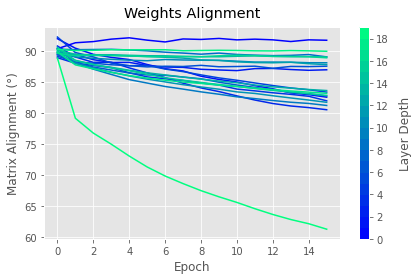

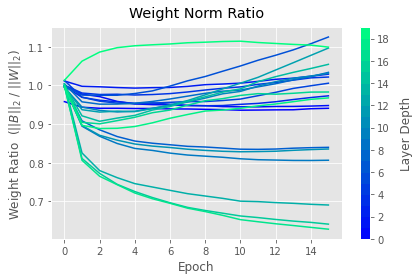

In [13]:
logs_dir = 'trained_models/cifar10/resnet20/fa_adam/logs'
xdata = list(range(0, 16))
layers_alignment = get_layer_alignment(logs_dir)
plot_multiple_lists(layers_alignment, 
                    xdata, 
                    'Epoch', 
                    'Matrix Alignment (°)', 
                    'Weights Alignment', 
                    'plots/resnet20/fa', 
                    'fa_angles_resnet_20_sgd', 
                    'winter')

layers_alignment = get_layer_weights(logs_dir)
plot_multiple_lists(layers_alignment, 
                    xdata, 
                    'Epoch', 
                    'Weight Ratio  ' + r'($||B||_2 ~/~ ||W||_2$)', 
                    'Weight Norm Ratio', 
                    'plots/resnet20/fa', 
                    'fa_weights_resnet_20_sgd',  
                    'winter')